In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Latent matrix from metadata

In [5]:
df = pd.read_csv('data/2019_oct_sort_1000.csv')

In [6]:
df.shape

(1000, 9)

In [7]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [8]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-18 10:54:45 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
1,2019-10-18 10:55:20 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
2,2019-10-31 06:25:30 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.46,513782162,00000056-a206-40dd-b174-a072550fa38c
3,2019-10-31 06:25:52 UTC,view,5100816,2053013553375346967,NaN,xiaomi,29.60,513782162,00000056-a206-40dd-b174-a072550fa38c
4,2019-10-31 06:23:12 UTC,view,1005115,2053013555631882655,electronics.smartphone,apple,955.84,513782162,00000056-a206-40dd-b174-a072550fa38c


In [9]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [10]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/tmp/ipykernel_3765/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [11]:
X_preprocessed.shape

(445, 8)

## Pricing criterion

In [12]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [13]:
X_merged = pricing_criterion(X_preprocessed)

In [14]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [15]:
X_meta = metadata(X_merged)

In [16]:
X_meta.set_index(X_meta['product_id'], inplace=True)

In [17]:
print(X_meta.shape)
X_meta.head()

(445, 12)


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
49800017,view,49800017,2126679654801604876,accessories bag,ritmix,12.32,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,low,accessories bag ritmix low
49800020,view,49800020,2126679654801604876,accessories bag,ritmix,15.43,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,medium,accessories bag ritmix medium
28401080,view,28401080,2053013566209917945,accessories bag,respect,66.67,516007189,000037a4-c043-4113-9b53-7bbb5d7c2bfe,13.8750,41.0500,high,accessories bag respect high
28719157,view,28719157,2116907519078040377,apparel shoes,salamander,127.42,532234792,00006cdc-ee07-41db-958a-232b53a1f4fd,72.5875,88.4875,high,apparel shoes salamander high
28717170,view,28717170,2053013565639492569,apparel shoes,respect,84.43,557816044,000097b7-14fd-4336-a0e6-c82c981f8817,72.5875,88.4875,medium,apparel shoes respect medium


### Count Vectorizer

In [311]:
count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)
count_df_1.head()

(445, 170)


,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
49800017,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49800020,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28401080,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28719157,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28717170,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [315]:
count_df_1 = count_df_1.reset_index()

In [316]:
len(list(set(count_df_1.index)))#.nunique()

445

In [317]:
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,product_id
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800017
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800020
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28401080
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28719157
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28717170


### Dimensionality reduction

In [22]:
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

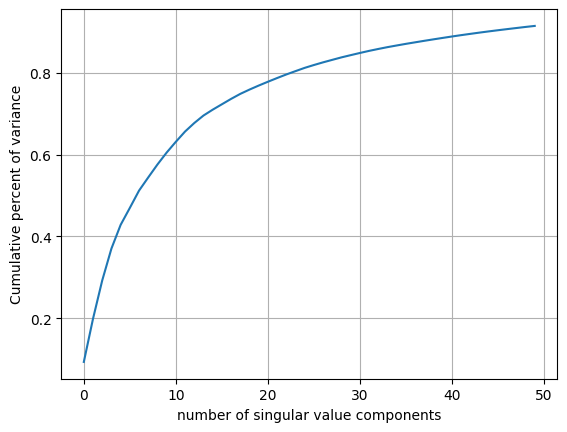

In [23]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [24]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

In [25]:
#n defined above
#n = 50
latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

(310, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
49800017,0.159126,0.094781,0.074467,0.867845,0.104342,0.451602,0.152625,-0.047068,0.053521,0.675642,...,-0.016846,-0.012123,-0.010143,-0.022212,-0.012294,-0.050580,0.010377,-0.010143,0.002608,-0.004086
49800020,0.409155,-0.382170,0.576855,-0.308769,0.238508,0.484030,0.073801,0.038980,0.071821,0.701121,...,-0.026251,0.022681,-0.006722,-0.014168,-0.015018,-0.051387,0.005832,-0.006434,-0.000783,-0.020950
28401080,0.265688,0.819887,-0.069625,-0.261478,0.272532,0.385874,0.291194,0.005876,0.199421,0.596432,...,0.016558,-0.031767,0.003699,-0.007374,-0.008264,-0.013475,0.000246,-0.009734,-0.005576,0.014261
28719157,0.274873,0.828929,-0.039082,-0.235706,0.326835,0.626002,0.366783,0.021173,0.926960,-0.465166,...,-0.030013,0.027579,0.005837,-0.023293,-0.015568,-0.008910,0.013176,-0.009738,-0.016608,-0.028035
28717170,0.424708,-0.360599,0.624793,-0.291207,0.327407,0.838738,0.194364,0.061150,1.015400,-0.473332,...,0.044540,-0.030875,-0.001499,0.023110,0.015101,0.020310,-0.007540,0.010285,0.004017,0.008177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901444,0.405871,-0.403868,0.573468,-0.335038,0.207657,0.363650,0.009501,0.043420,0.016501,0.069495,...,0.012381,-0.005023,-0.002544,0.016654,0.035728,0.008315,-0.018752,-0.087221,0.042868,0.013493
10400294,0.156276,0.073684,0.071730,0.851527,0.074652,0.338353,0.090313,-0.043913,-0.001854,0.045490,...,0.036707,-0.060324,-0.006456,0.013690,0.072143,0.019630,-0.044550,-0.185214,0.087525,0.093279
10400334,0.406306,-0.403267,0.574117,-0.325087,0.208818,0.370782,0.011488,0.042135,0.016445,0.070969,...,0.027302,-0.025520,-0.003035,0.021734,0.069418,0.018823,-0.049095,-0.181505,0.084134,0.076415
10400398,0.259958,0.803929,-0.085135,-0.281876,0.228669,0.213571,0.211477,0.002942,0.025685,0.052357,...,-0.017096,0.016897,-0.003031,-0.035743,-0.126943,-0.082524,0.067165,0.492327,-0.216754,0.038537


In [26]:
latent_df_1.reset_index().drop_duplicates().shape

(310, 51)

In [27]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [28]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [29]:
df_event = preprocessing_event(df)

In [127]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [128]:
df_event['rating'] = df_event['event_type'].map(dct)

In [129]:
df_event["rating"].sum()

743

In [130]:
df_rating.shape

(310, 186)

In [131]:
df_rating = df_event.pivot_table(values='rating',
                                 index='product_id',
                                 columns='user_id',
                                 aggfunc="sum").fillna(0)
df_rating

user_id,512483064,512561891,512600925,512625864,512652590,512843699,512845701,512893095,513035269,513160929,...,563123464,563195675,563543861,563842008,564098956,564240719,564555327,564879838,565847508,566031240
product_id,,,,,,,,,,,,,,,,,,,,,
1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
df_rating.sum().reset_index()[0].sum()

743.0

In [133]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    743
dtype: int64

In [134]:
df_rating.reset_index()

user_id,product_id,512483064,512561891,512600925,512625864,512652590,512843699,512845701,512893095,513035269,...,563123464,563195675,563543861,563842008,564098956,564240719,564555327,564879838,565847508,566031240
0,1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,49800017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
svd = TruncatedSVD(n_components=75)
latent_df_2 = svd.fit_transform(df_rating)

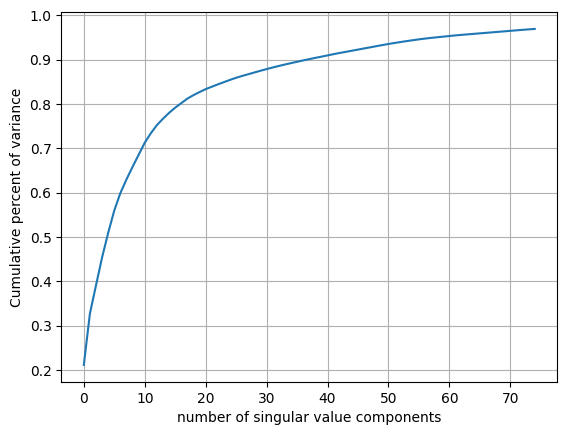

In [136]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [137]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
1002532,-6.539314e-18,1.057458e-16,4.839490e-15,5.369369e-16,9.765048e-15,1.006447e-14,4.634662e-14,-8.195597e-13,4.775168e-13,-2.640394e-13,...,0.000040,-0.000043,-0.000043,-0.000021,-0.000056,-0.000026,0.000085,-0.000307,0.000132,-0.000066
1002540,1.640621e-19,6.513066e-17,-1.820429e-15,-7.687089e-17,-2.454539e-15,-4.395765e-15,-6.787763e-15,2.347850e-13,-1.360601e-13,1.156547e-13,...,-0.000004,0.000004,0.000004,0.000002,0.000005,0.000001,-0.000007,0.000010,-0.000009,0.000014
1002542,2.123614e-04,4.223970e-08,-9.475024e-14,-3.240946e-14,-1.355314e-13,-5.249881e-06,-1.802384e-04,-3.229915e-06,-1.243893e-11,-8.501256e-08,...,0.000239,-0.000213,0.000128,0.000650,-0.000342,0.001696,0.000498,0.007297,-0.001084,-0.008251
1002544,5.367606e+00,-4.998541e-04,4.519837e-13,3.093026e-14,4.960727e-13,5.030703e-01,4.515955e+00,1.861108e-01,3.830878e-11,-6.335104e-03,...,-0.000248,-0.000252,-0.000449,0.000352,0.000354,-0.010427,-0.003956,-0.050683,-0.006798,0.038271
1002633,7.973937e-02,8.646383e-06,-7.286507e-14,-1.912774e-14,-7.406733e-14,-4.689849e-04,-1.237798e-02,-1.750773e-04,-8.444543e-12,-4.074826e-06,...,0.000058,-0.000095,-0.000014,0.000251,-0.000370,0.001020,0.001033,0.003143,-0.000687,-0.007990


In [138]:
latent_df_2.shape

(310, 75)

# Apply Cosine Similarity in Content and Collaborative Matrices


In [285]:
product_id = 28718072

In [286]:
# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df_1.loc[product_id]).reshape(1, -1)
v2 = np.array(latent_df_2.loc[product_id]).reshape(1, -1)

# Compute the cosine similarity of this movie with the others in the list
sim1 = cosine_similarity(latent_df_1, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

In [287]:
#'hybrid_similarity = (content_similarity + collaborative_similarity) / 2`

# hybrid = ((sim1 + sim2)/2.0)


In [288]:
dictDf_1 = {'features': sim1} 
recommendation_df_1 = pd.DataFrame(dictDf_1, index = latent_df_1.index)
# recommendation_df_1.sort_values('features', ascending=False, inplace=True)

In [289]:
dictDf_2 = {'ratings': sim2} 
recommendation_df_2 = pd.DataFrame(dictDf_2, index = latent_df_2.index)
# recommendation_df_2.sort_values('ratings', ascending=False, inplace=True)

In [290]:
recommendation_combined = pd.merge(recommendation_df_1, recommendation_df_2, left_index=True, right_index=True)

In [291]:
recommendation_combined['hybrid'] = ((recommendation_combined['features'] + recommendation_combined['ratings'])/2.0)

In [294]:
recommendation_combined.sort_values('hybrid', ascending=False).head(10)

,features,ratings,hybrid
28718072,1.000000,1.000000,1.000000
28704388,0.480745,1.000000,0.740373
28717920,0.591117,0.656206,0.623661
2800501,0.261880,0.895043,0.578462
2300294,0.254050,0.880137,0.567094
2701646,0.223639,0.880137,0.551888
2900957,0.245229,0.832369,0.538799
1801689,0.225841,0.808284,0.517062
7005036,0.258598,0.768113,0.513356
1801849,0.001591,0.896976,0.449284


In [346]:
def top_n_products(product_id, rec_df, meta_df, n=10):
    # Features
    feat_idx = rec_df.sort_values('features', ascending=False).index[0:n]
    counter = 0
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        
        if counter == 0:
            print(f"Top {n} recommendations for product_id {product_id}:")
            print(f"{i} - {meta_text} \n")
#             print("-----------------------")

        else:
            print(f"Rec {counter}) {i} - {meta_text}")
        
        counter += 1

In [347]:
recommendation_df_1.loc[28718072]

features    1.0
Name: 28718072, dtype: float64

In [348]:
top_n_products(28718072, recommendation_df_1, X_meta)

Top 10 recommendations for product_id 28718072:
28718072 - apparel shoes respect low 

Rec 1) 28713027 - apparel shoes baden low
Rec 2) 28713076 - apparel shoes baden low
Rec 3) 28716666 - apparel shoes respect high
Rec 4) 28717170 - apparel shoes respect medium
Rec 5) 28716678 - apparel shoes respect medium
Rec 6) 28717370 - apparel shoes keds escan low
Rec 7) 28717939 - apparel shoes cavaletto high
Rec 8) 28719157 - apparel shoes salamander high
Rec 9) 28717920 - apparel shoes rieker medium
